In [99]:

!pip install tweet-preprocessor
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB , GaussianNB
from sklearn.ensemble import RandomForestClassifier
!pip install pandas
import pandas as pd
import numpy as np
import preprocessor as p
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
import string
import spacy
from sklearn.model_selection import train_test_split
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [112]:
dataset_url='https://www.kaggle.com/kazanova/sentiment140/download'
df=pd.read_csv(dataset_url)
df.columns = ['Target', 'userid', 'Date','Query','Username','tweet']
print(df.head())
#Removing the duplicates
df.drop_duplicates(subset=['tweet', 'userid'],keep = False, inplace = True)

del df['Query']
del df['Date']
del df['userid']
del df['Username']


df=df.sample(frac = 0.3)
df=df.reset_index(drop=True)
df.head()
df['tweet']=df['tweet'].apply(p.clean)
df.head()


   Target      userid                          Date     Query       Username  \
0       0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY  scotthamilton   
1       0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY       mattycus   
2       0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY        ElleCTF   
3       0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY         Karoli   
4       0  1467811372  Mon Apr 06 22:20:00 PDT 2009  NO_QUERY       joy_wolf   

                                               tweet  
0  is upset that he can't update his Facebook by ...  
1  @Kenichan I dived many times for the ball. Man...  
2    my whole body feels itchy and like its on fire   
3  @nationwideclass no, it's not behaving at all....  
4                      @Kwesidei not the whole crew   


,Target,tweet
0,0,/me gets &quot;Your video will start in second...
1,0,I want a cardigan
2,4,Sims is pure AWESOME-ness! created simon Cowel...
3,0,Watching bolt by myself
4,4,"wow, i really cant believe you are answering e..."


In [101]:

# Create our list of punctuation marks
punctuations = string.punctuation

# Create our list of stopwords
nlp = spacy.load('en_core_web_sm')
stop_words = spacy.lang.en.stop_words.STOP_WORDS
df['tweet']=df['tweet'].apply(p.clean)
# Load English tokenizer, tagger, parser, NER and word vectors
parser = English()

# Creating our tokenizer function
def spacy_tokenizer(sentence):
    # Creating our token object, which is used to create documents with linguistic annotations.
    #doc=nlp(sentence)
    #sentence = nlp(sentence)
    mytokens = parser(sentence)
    
    # Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in nlp(str(mytokens))]
    
    #mytokens = [word.lemma_ for word in nlp(str(mytokens))]
    #print(mytokens)
    # Removing stop words
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

    # return preprocessed list of tokens
    
    return mytokens


In [102]:
# Custom transformer using spaCy
class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        # Cleaning Text
        return [clean_text(text) for text in X]

    def fit(self, X, y=None, **fit_params):
        return self

    def get_params(self, deep=True):
        return {}

# Basic function to clean the text
def clean_text(text):
    # Removing spaces and converting text into lowercase
    return text.strip().lower()

In [103]:
bow_vector = CountVectorizer(tokenizer = spacy_tokenizer, ngram_range=(1,2))
tfidf_vector = TfidfVectorizer(tokenizer = spacy_tokenizer)

X = df['tweet'] # the features we want to analyze
ylabels = df['Target'] # the labels, or answers, we want to test against

X_train, X_test, y_train, y_test = train_test_split(X, ylabels, test_size=0.3)

In [109]:
from sklearn import metrics
LR_classifier = LogisticRegression( max_iter=10000)

# Create pipeline using Bag of Words
pipe = Pipeline([("cleaner", predictors()),
                 ('vectorizer', bow_vector),
                 ('classifier', LR_classifier)])

# model generation
pipe.fit(X_train,y_train)
predicted = pipe.predict(X_test)
print('Logistic Regression with BOW',metrics.accuracy_score(y_test, predicted))


pipe = Pipeline([("cleaner", predictors()),
                 ('vectorizer', tfidf_vector),
                 ('classifier', LR_classifier)])
pipe.fit(X_train,y_train)
predicted = pipe.predict(X_test)
print('Logistic Regression with TF-IDF',metrics.accuracy_score(y_test, predicted))


Logistic Regression with BOW 0.7267223382045929
Logistic Regression with TF-IDF 0.7304801670146138


In [ ]:
rf_model = DecisionTreeClassifier()
pipe = Pipeline([("cleaner", predictors()),
                 ('vectorizer', tfidf_vector),
                 ('classifier', rf_model)])
pipe.fit(X_train,y_train)
predicted = pipe.predict(X_test)
print('RF  with TF-IDF', metrics.accuracy_score(predicted, y_test))

pipe = Pipeline([("cleaner", predictors()),
                 ('vectorizer', bow_vector),
                 ('classifier', rf_model)])

# model generation
pipe.fit(X_train,y_train)
predicted = pipe.predict(X_test)
print('Logistic Regression with BOW',metrics.accuracy_score(y_test, predicted))
# pipe.score(X_test, y_test

In [ ]:
nb_clf = MultinomialNB()
pipe = Pipeline([("cleaner", predictors()),
                 ('vectorizer', tfidf_vector),
                 ('classifier', nb_clf)])
pipe.fit(X_train,y_train)
predicted = pipe.predict(X_test)
print('Naive Bayes with TF-IDF', metrics.accuracy_score(predicted, y_test))
pipe = Pipeline([("cleaner", predictors()),
                 ('vectorizer', bow_vector),
                 ('classifier', nb_clf)])
pipe.fit(X_train,y_train)
predicted = pipe.predict(X_test)
print('Naive  with BOW', metrics.accuracy_score(predicted, y_test))

In [ ]:
from sklearn.ensemble import  VotingClassifier
#svm_clf = svm.SVC(kernel='linear',probability=False)
nb_clf = MultinomialNB()
LR_classifier = LogisticRegression( max_iter=10000)
rf_clf = RandomForestClassifier()
ensemble= VotingClassifier(estimators=[('lr', nb_clf), ('gnb', LR_classifier),('rf',rf_clf)],voting='soft')
#ensemble = VotingClassifier(estimators, voting=’hard’)
pipe = Pipeline([("cleaner", predictors()),
                 ('vectorizer', tfidf_vector),
                 ('classifier', ensemble)])

#fit model to training data
pipe.fit(X_train, y_train)
predicted = pipe.predict(X_test)
print('Naive  with BOW', metrics.accuracy_score(predicted, y_test))
# #test our model on the test data



pipe = Pipeline([("cleaner", predictors()),
                 ('vectorizer', bow_vector),
                 ('classifier', nb_clf)])

# model generation
pipe.fit(X_train,y_train)
predicted = pipe.predict(X_test)
print('Logistic Regression with BOW',metrics.accuracy_score(y_test, predicted))

In [ ]:
Vaccine_tweets = "Sputnik.csv"
vaccine_keywords = '#Sputnik'
tweet_scraper(vaccine_keywords, Vaccine_tweets)

Vaccine_tweets = "Moderna.csv"
vaccine_keywords = '#Moderna'
tweet_scraper(vaccine_keywords, Vaccine_tweets)

Vaccine_tweets = "AstraZeneca.csv"
vaccine_keywords = '#AstraZeneca'
tweet_scraper(vaccine_keywords, Vaccine_tweets)

Vaccine_tweets = "Pfizer.csv"
vaccine_keywords = '#Pfizer'
tweet_scraper(vaccine_keywords, Vaccine_tweets)

In [115]:

df2 = pd.read_csv('#Moderna.csv')
df2['Label'] = pipe.predict(df2['tweet'])

df3 = pd.read_csv('#Pfizer.csv')
df3['Label'] = pipe.predict(df3['tweet'])

df4 = pd.read_csv('#AstraZeneca.csv')
df4['Label'] = pipe.predict(df4['tweet'])
df5 = pd.read_csv('#Covishield.csv')
df5['Label'] = pipe.predict(df5['tweet'])

df6 = pd.read_csv('#Sputnik.csv')
df6['Label'] = pipe.predict(df6['tweet'])


In [194]:
# years = ['CA','Canada', 'Ontario']
# df2.year.isin(years)

# df.loc[df['column_name'].isin(some_values)]
df2_can=pd.DataFrame()
df2_usa=pd.DataFrame()
df3_usa=pd.DataFrame()
df3_can=pd.DataFrame()
df4_usa=pd.DataFrame()
df4_can=pd.DataFrame()
# df2_can=df2[df2.location.str.contains('Canada' ,regex= True, na=False)]
# # df2[df2.location.str.contains('Ontario' ,regex= True, na=False)]
# print(df2_can.head())
# print(df2_can.info())
CanadaList=['Ontario, Canada, CAN, can, CANADA','Toronto','Montreal','Quebec','British Columbia','Manitoba','New Brusnwick','Niagra','Nova Scotia','Saskatchwen','Toronto']
USStates=['USA','America','U.S.A','Alabama','Alaska','Arizona','Arkansas','California','Colorado','Connecticut','Delaware','Florida','Georgia','Hawaii','Idaho','Illinois','Indiana','Iowa','Kansas','Kentucky','Louisiana','Maine','Maryland','Massachusetts','Michigan','Minnesota','Mississippi','Missouri','Montana','Nebraska','Nevada','New Hampshire','New Jersey','New Mexico','New York','North Carolina','North Dakota','Ohio','Oklahoma','Oregon','Pennsylvania','Rhode Island','South Carolina','South Dakota','Tennessee','Texas','Utah ','Vermont','Washington','West Virginia''Wisconsin','Wyoming']

indian_states=["Andhra Pradesh","Arunachal Pradesh ","Assam","Bihar","Chhattisgarh","Goa","Gujarat","Haryana","Himachal Pradesh","Jammu and Kashmir","Jharkhand","Karnataka","Kerala","Madhya Pradesh","Maharashtra","Manipur","Meghalaya","Mizoram","Nagaland","Odisha","Punjab","Rajasthan","Sikkim","Tamil Nadu","Telangana","Tripura","Uttar Pradesh","Uttarakhand","West Bengal","Andaman and Nicobar Islands","Chandigarh","Dadra and Nagar Haveli","Daman and Diu","Lakshadweep","National Capital Territory of Delhi","Puducherry",'India','INDIA']

for state in CanadaList:
    df2_can=df2_can.append(df2[df2.location.str.contains(state ,regex= True, na=False)])

# df2_can=df2_can.append(df2[df2.location.str.contains('Ontario' ,regex= True, na=False)])

for state in USStates:
    df3_usa=df3_usa.append(df3[df3.location.str.contains(state ,regex= True, na=False)])

for state in CanadaList:
    df3_can=df3_can.append(df3[df3.location.str.contains(state ,regex= True, na=False)])

for state in USStates:
    df2_usa=df3_can.append(df3[df3.location.str.contains(state ,regex= True, na=False)])


    
for state in CanadaList:
    df4_can=df4_can.append(df4[df4.location.str.contains(state ,regex= True, na=False)])

# df2_can=df2_can.append(df2[df2.location.str.contains('Ontario' ,regex= True, na=False)])

for state in USStates:
    df4_usa=df4_usa.append(df4[df4.location.str.contains(state ,regex= True, na=False)])
    

1    3792
0    3357
Name: Label, dtype: int64
1    447
0    427
Name: Label, dtype: int64
None
4    125
0    119
Name: Label, dtype: int64
None


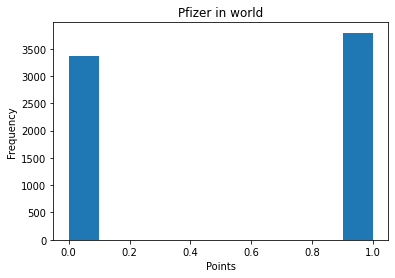

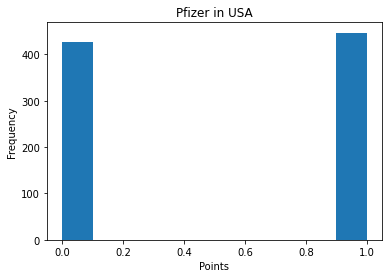

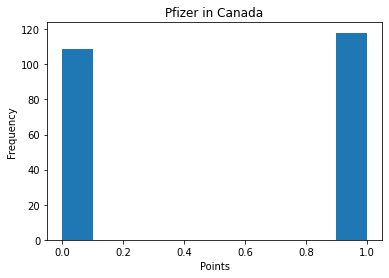

In [197]:
df3['Label'] = df3['Label'].replace([4],1)
print(df3['Label'].value_counts())
fig, ax = plt.subplots()

ax.hist(df3['Label'])
# set title and labels
ax.set_title('Pfizer in world')
ax.set_xlabel('Points')
ax.set_ylabel('Frequency')
plt.plot()
plt.savefig('Pfizer_in_world.png')
print('53 % positive ')


print(print(df3_usa['Label'].value_counts()))
fig, ax = plt.subplots()
# plot histogram
ax.hist(df3_usa['Label'])
# set title and labels
ax.set_title('Pfizer in USA')
ax.set_xlabel('Points')
ax.set_ylabel('Frequency')
plt.plot()
plt.savefig('Pfizer_in_usa.png')
print('51 % positive ')

print(print(df3_can['Label'].value_counts()))
fig, ax = plt.subplots()
# plot histogram
ax.hist(df3_can['Label'])
# set title and labels
ax.set_title('Pfizer in Canada')
ax.set_xlabel('Points')
ax.set_ylabel('Frequency')
plt.plot()
print('52 % positive ')
plt.savefig('Pfizer_in_can.png')




4    5625
0    4582
Name: Label, dtype: int64
None
4    125
0    119
Name: Label, dtype: int64
None
1    119
0    109
Name: Label, dtype: int64
None


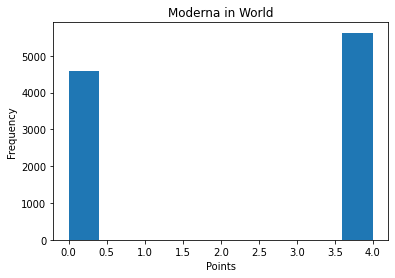

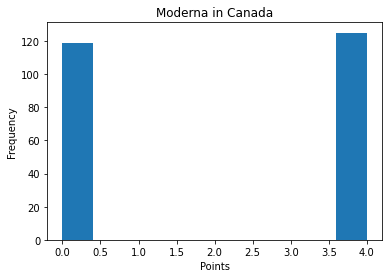

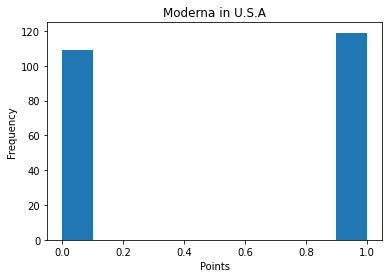

In [198]:
print(print(df2['Label'].value_counts()))
#55 % positive 
fig, ax = plt.subplots()
# plot histogram
ax.hist(df2['Label'])
# set title and labels
ax.set_title('Moderna in World')
ax.set_xlabel('Points')
ax.set_ylabel('Frequency')
plt.plot()
print('55 % positive ')
plt.savefig('Moderna_in_world.png')

print(print(df2_can['Label'].value_counts()))
#51% positive
fig, ax = plt.subplots()
# plot histogram
ax.hist(df2_can['Label'])
# set title and labels
ax.set_title('Moderna in Canada')
ax.set_xlabel('Points')
ax.set_ylabel('Frequency')
plt.plot()
print('55 % positive ')
plt.savefig('Moderna_in_Canada.png')

print(print(df2_usa['Label'].value_counts()))
#52% positive
fig, ax = plt.subplots()
# plot histogram
ax.hist(df2_usa['Label'])
# set title and labels
ax.set_title('Moderna in U.S.A')
ax.set_xlabel('Points')
ax.set_ylabel('Frequency')
plt.plot()
print('52 % positive ')
plt.savefig('Moderna_in_USA.png')

In [84]:
# #import svm model
# from sklearn import svm

# #Create a svm Classifier
# svm_clf = svm.SVC(kernel='linear') # Linear Kernel

# pipe = Pipeline([("cleaner", predictors()),
#                  ('vectorizer', tfidf_vector),
#                  ('classifier', svm_clf)])
# pipe.fit(X_train,y_train)
# print('SVM with TF-IDF',pipe.score(X_test, y_test))

# pipe = Pipeline([("cleaner", predictors()),
#                  ('vectorizer', bow_vector),
#                  ('classifier', svm_clf)])
# pipe.fit(X_train,y_train)
# print('SVM with BOW', pipe.score(X_test, y_test))


In [85]:

# pipe.score(X_test, y_test)

In [86]:
# pipe.score(X_test, y_test)

In [91]:
df2=pd.read_csv('ModernaVaccine.csv')
df2=df2.drop(df2.columns[[0,1,2,3,5,6,7,8,9,10,11,12,13]],axis=1)

In [88]:
df2.head()

,clean_text
0,Both shots done
1,Your daily Morning market update th April
2,How mRNA Vaccine Moderna/Pfizer works
3,Why need Two Doses mRNA Vaccine
4,Thanks thank making safe travel today surprise...


In [92]:
df2.rename(columns={"clean_text": "tweet"})

,tweet
0,Both shots done
1,Your daily Morning market update th April
2,How mRNA Vaccine Moderna/Pfizer works
3,Why need Two Doses mRNA Vaccine
4,Thanks thank making safe travel today surprise...
...,...
3866,Why need Two Doses mRNA Vaccine
3867,Why need Two Doses mRNA Vaccine
3868,Why need Two Doses mRNA Vaccine
3869,Why need Two Doses mRNA Vaccine


In [96]:
df2=df2.dropna()
#df2['target']=np.nan

df2.info()
df2['tweet']=df2['tweet'].apply()
y_pred=pipe.predict(df2.iloc[0,0])
# for i in range (0,df2.shape[0]-1):
#   df2.iloc[i,1]=pipe.predict(df2.iloc[i,0])

print(y_pred)
#df2['target']=y_pred

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3869 entries, 0 to 3870
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   clean_text  3869 non-null   object
dtypes: object(1)
memory usage: 60.5+ KB
[0 0 0 4 0 0 4 0 0 0 0 0 0 0 4]
